# 3. Deep Learning Model: Autoencoders

To recommend movies to users with a lot of ratings, we decided to use an Autoencoder Neural Network. The reason behind that choice is two-fold: first, Autoencoders are very easy to implement and understand (they are 'simple' models) and second, they often perform very well for personalization problems. 

## 3.1 Get the datasets

We decided to apply this model on users with the most ratings and we established the following business rule: all users with more ratings than the 3rd quartile of the number of the ratings. Based on our training set for example, the 3rd quartile is 41 ratings and we will therefore train our model on data that contains the ratings of users who rated more than 41 movies. 

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras 
from keras import backend as K
import itertools
import pickle

In [2]:
#import the data
train_set = pd.read_csv('inputs/train_sample_ratings.csv')
train_set = train_set[['userId', 'movieId', 'rating', 'timestamp']]

test_set = pd.read_csv('inputs/test_sample_ratings.csv')
test_set = test_set[['userId', 'movieId', 'rating', 'timestamp']]

val_set = pd.read_csv('inputs/val_sample_ratings.csv')
val_set = val_set[['userId', 'movieId', 'rating', 'timestamp']]

In [3]:
def user_split(data, user_col, quant):
    distribution = pd.DataFrame(data[user_col].value_counts().rename_axis('userId').reset_index(name = 'counts'))
    thresh = distribution.counts.quantile(quant)
    user_ids = distribution[distribution.counts > thresh]
    users_ids = user_ids[user_col].to_list()
    print('the new dataset contains', round(len(user_ids)/len(distribution)*100, 2), '% of the users of the initial dataset')

    model_train = data[data[user_col].isin(users_ids)]
    print('the new dataset contains', round(len(model_train)/len(data)*100, 2), '% of the ratings in the initial dataset')

    return model_train

In [4]:
deep_train = user_split(train_set, 'userId', 0.75)
deep_test = user_split(test_set, 'userId', 0.75)
deep_val = user_split(val_set, 'userId', 0.75)

the new dataset contains 24.96 % of the users of the initial dataset
the new dataset contains 55.17 % of the ratings in the initial dataset
the new dataset contains 24.38 % of the users of the initial dataset
the new dataset contains 54.57 % of the ratings in the initial dataset
the new dataset contains 22.71 % of the users of the initial dataset
the new dataset contains 52.53 % of the ratings in the initial dataset


After spliting the train, test and validation set, we realized that some of the movies in the new training/test sets were missing from the validation set. This is due to the fact that some movies received very few ratings and the users who gave these ratings gave less ratings than the one established by our business rule. 

Because our autoencoders need to receive inputs of the same dimension across datasets, we remove these movies from the new training and test sets. 

In [5]:
def remove_movie(deep_training, deep_testing, deep_validation, val):
    absent_movies = [movie for movie in val.movieId.unique() if movie not in deep_validation.movieId.unique()]
    missing_movies = [movie for movie in deep_training.movieId.unique() if movie not in deep_validation.movieId.unique()]
    missing_movies = absent_movies + missing_movies

    if len(absent_movies)>0:
        deep_training = deep_training[~(deep_training['movieId'].isin(missing_movies))]
        deep_testing = deep_testing[~(deep_testing['movieId'].isin(missing_movies))]
    
    return deep_training, deep_testing

In [6]:
deep_train, deep_test = remove_movie(deep_train, deep_test, deep_val, val_set)

## 3.2 Loss Function and Evaluation Metric 

We will then create our matrix for each dataset. One potential issue for Autoencoders is that they do not support NaN values and we therefore need to impute them in order to train the model. We tried 3 differents imputation and we will keep the one that performs the best: mean of the ratings, median of the ratings, and mode of the ratings. 

To evaluate this model, we are using a specific loss and evaluation metric: Masked MSE and Masked RMSE. The reason behind that choice is that we don't want to compute the errors on the data that were NaN initially.

$$ MMSE = \frac{m_i * (r_i - y_i)^2}{\sum_{i=0}^n m_i} $$ 

where $r_{i}$ is the real rating, $y_{i}$ is the predicted rating and $m_{i}$ is the mask, which is equal to 0 when $r_{i}$ was imputed and 1 otherwise.

In order to introduce that mask correctly and avoid that it will be applied on data that had the median or the mode as a true value, we adjust the imputation by -0.005 for the median and the mode imputation method.

In [7]:
#create the input matrix with a selected imputation method
def create_matrix(data, imputation_method):
    #data = data.fillna(-1)
    matrix = data.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
    #matrix = matrix.replace(-1, np.nan)

    if imputation_method == 'mean':
        mean = data.rating.mean()
        matrix = matrix.fillna(mean)
        eval_value = mean

    elif imputation_method == 'median':
        median = data.rating.median()
        matrix = matrix.fillna(median-0.005)
        eval_value = median-0.005

    elif imputation_method == 'mode':
        mode = data.rating.mode()[0]
        matrix = matrix.fillna(mode-0.005)
        eval_value = mode-0.005

    return matrix, eval_value

In [8]:
#loss function
def MMSE(pred, true):
    m_i = K.cast(K.not_equal(true, eval_value), K.floatx())
    r_i_y_i = K.square(m_i * (true - pred))
    mmse = K.sum(r_i_y_i, axis=-1) / K.maximum(K.sum(m_i, axis=-1), 1)
    
    return mmse

In [9]:
#evaluation metric
def MRMSE(pred, true):
    m_i = K.cast(K.not_equal(true, eval_value), K.floatx())
    pred_clip = K.clip(pred, 1, 5)
    r_i_y_i = K.square(m_i * (true - pred_clip))
    MRMSE = K.sqrt(K.sum(r_i_y_i, axis=-1) / K.maximum(K.sum(m_i, axis=-1), 1))
    
    return MRMSE

In [10]:
#define the autoencoder model
def model_auto(train, param_reg, encoder_act, ls_act, decoder_act, drop_rate):
  #input
  input = keras.Input(shape = (train.shape[1],))

  #encoder
  encoded = keras.layers.Dense(512, activation= encoder_act, kernel_regularizer = keras.regularizers.l2(param_reg))(input)
  encoded = keras.layers.Dense(256, activation= encoder_act, kernel_regularizer = keras.regularizers.l2(param_reg))(encoded)

  #latent space
  latent_space = keras.layers.Dense(64, activation=ls_act, kernel_regularizer = keras.regularizers.l2(param_reg))(encoded)

  #dropout to avoid overfit
  drop_out = keras.layers.Dropout(rate = drop_rate)(latent_space)

  #decoder
  decoded = keras.layers.Dense(256, activation= decoder_act, kernel_regularizer = keras.regularizers.l2(param_reg))(drop_out)
  decoded = keras.layers.Dense(512, activation= decoder_act, kernel_regularizer = keras.regularizers.l2(param_reg))(drop_out)

  #output
  output = keras.layers.Dense(train.shape[1])(decoded)

  auto_model = keras.Model(input, output)

  return auto_model

In [11]:
#plots the train and test curves
def plot_history(model_history, metric, val_metric):
  plt.plot(model_history.history[metric])
  plt.plot(model_history.history[val_metric])
  plt.title(metric + ' across epochs')
  plt.xlabel('epoch')
  plt.ylabel(metric)
  plt.legend(['training', 'validation'], loc = 'best')
  plt.show()

## 3.3 Try The 3 Imputation Methods and Optimize the Models

We now apply our model on data for which NaN have been imputed using the 3 different imputation methods. 

We also want to optimize our model for each imputation method in terms of regularization parameter and learning rate.

We tried the values 0.1, 0.01, 0.001, 0.0001, 0.00001 for both parameters.   

In [12]:
import itertools
def get_hyperparam_combos(reg_params, lr_params):
    a = [reg_params, lr_params]
    return list(itertools.product(*a))

In [13]:
def cross_validation(train, val, reg_params, lr_params, epoch, batch):
    best_rmse = float('inf')
    for (reg, lr) in get_hyperparam_combos(reg_params, lr_params):
        autoencoder = model_auto(train, reg, 'elu', 'elu', 'elu', 0.3)
        autoencoder.compile(optimizer= keras.optimizers.Adam(lr = lr), loss=MMSE, metrics = [MRMSE])
        history = autoencoder.fit(train, train,
                epochs= epoch,
                batch_size=batch,
                shuffle=True,
                validation_data=(val, val), verbose = False)
        mrmse = history.history['val_MRMSE']

        if max(mrmse) < best_rmse:
            best_rmse = max(mrmse)
            best_model = history
            best_params = (reg, lr)
    
    plot_history(best_model, 'MRMSE', 'val_MRMSE')
    plot_history(best_model, 'loss', 'val_loss')

    return best_rmse, best_model, best_params

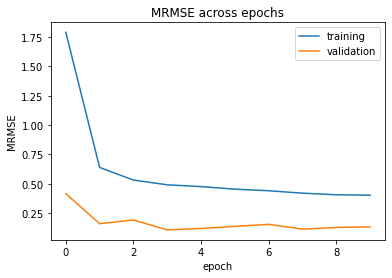

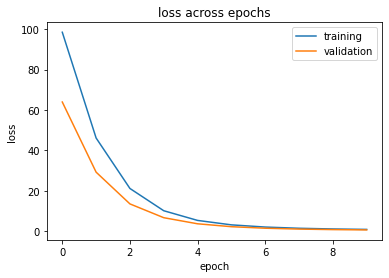

In [14]:
deep_train_matrix_mode, eval_value = create_matrix(deep_train, 'mode')
deep_val_matrix_mode, eval_value = create_matrix(deep_val, 'mode')
best_rmse, best_model, best_params = cross_validation(deep_train_matrix_mode, deep_val_matrix_mode, [0.1, 0.01, 0.001, 0.0001, 0.00001], [0.1, 0.01, 0.001, 0.0001, 0.00001], 10, 256)


### Here, we see what is the best imputation strategy out of mean, median, and mode imputation. We will plot the loss and MRMSE of the optimized hyperparameter model for each imputation strategy

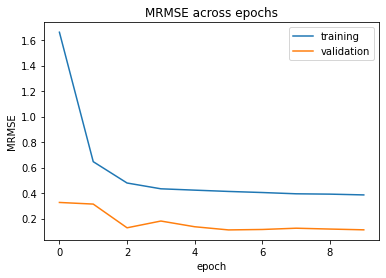

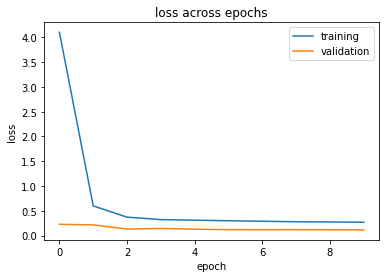

In [15]:
# For mode imputation
deep_train_matrix_mode, eval_value = create_matrix(deep_train, 'mode')
deep_val_matrix_mode, eval_value = create_matrix(deep_val, 'mode')
best_rmse_mode, best_model_mode, best_params_mode = cross_validation(deep_train_matrix_mode, deep_val_matrix_mode, [0.1, 0.01, 0.001, 0.0001, 0.00001], [0.1, 0.01, 0.001, 0.0001, 0.00001], 10, 256)

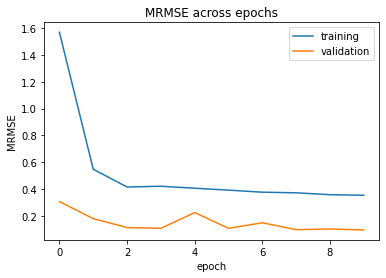

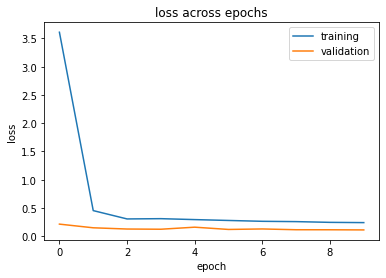

In [16]:
# For median imputation
deep_train_matrix_median, eval_value = create_matrix(deep_train, 'median')
deep_val_matrix_median, eval_value = create_matrix(deep_val, 'median')
best_rmse_median, best_model_median, best_params_median = cross_validation(deep_train_matrix_median, deep_val_matrix_median, [0.1, 0.01, 0.001, 0.0001, 0.00001], [0.1, 0.01, 0.001, 0.0001, 0.00001], 10, 256)

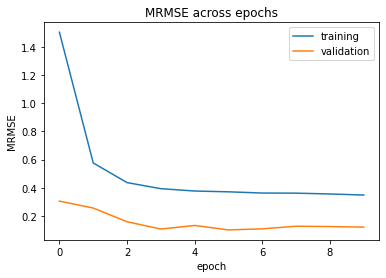

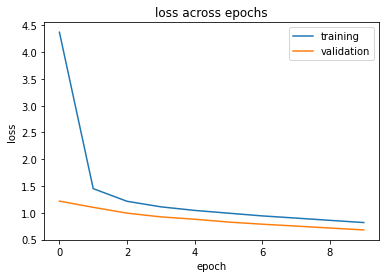

In [17]:
# For mean imputation
deep_train_matrix_mean, eval_value = create_matrix(deep_train, 'mean')
deep_val_matrix_mean, eval_value = create_matrix(deep_val, 'mean')
best_rmse_mean, best_model_mean, best_params_mean = cross_validation(deep_train_matrix_mean, deep_val_matrix_mean, [0.1, 0.01, 0.001, 0.0001, 0.00001], [0.1, 0.01, 0.001, 0.0001, 0.00001], 10, 256)

## 3.4 Select the Best Model

We now want to see which one is our best model. We see in the code below that it is the model with the mean imputation. The best learning rate is 0.001 with a regularization parameter of 0.0001.

In [23]:
#get the best model
best_all_rmse = np.argmin([best_rmse_median, best_rmse_mean, best_rmse_mode])
models_option = ['median imputation', 'mean imputation', 'mode imputation']

print('The best model uses', models_option[best_all_rmse])

The best model uses mean imputation


In [31]:
#evaluate with the best model
deep_test_matrix_mean, eval_value_test = create_matrix(deep_test, 'mean')
evaluation_results = best_model_mean.model.evaluate(deep_test_matrix_mean, deep_test_matrix_mean, verbose = False)
print('The loss on the validation set is', evaluation_results[0])
print('The MRMSE on the validation set is', evaluation_results[1])

The loss on the validation set is 0.7099889516830444
The MRMSE on the validation set is 0.19752834737300873


In [33]:
predictions = pd.DataFrame(best_model_mean.model.predict(deep_test_matrix_mean))
predictions.columns = deep_test_matrix_mean.columns
predictions.index = deep_test_matrix_mean.index

In [42]:
def create_recommendations(autoencoder_predict_df):
    user_recs = {}
    for userId, row in autoencoder_predict_df.iterrows():
        best_movies = list(row.sort_values(ascending=False).index)
        best_movies = [int(x) for x in best_movies][:10]
        user_recs[userId] = best_movies
    file_to_write = open("outputs/DL_recommendations.pickle", "wb")
    pickle.dump(user_recs, file_to_write)

create_recommendations(predictions)